In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import csv
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from scipy.spatial import cKDTree

In [4]:
DATA_BUS_STOPS = "./data/bus-stops.csv"
DATA_BUS_SEQUENCES = "./data/bus-sequences.csv"
DATA_LONDON = "./data/londonUTLA_full.csv"
DATA_POPULATION = "./data/LSOA_(Dec_2011)_Population_Weighted_Centroids_in_England_and_Wales.csv"
DATA_GREEN_SPACE = "./data/green_space.csv"

In [5]:
# import and parse dataset
bus_stops = pd.read_csv(DATA_BUS_STOPS, header=0, dtype={'Location_Easting': float, 'Location_Northing': float})
bus_stops = bus_stops[['Stop_Code_LBSL', 'Location_Easting', 'Location_Northing']]
bus_stops.columns = ['id', 'x', 'y']

routes = pd.read_csv(DATA_BUS_SEQUENCES, header=0, dtype={'Location_Easting': float, 'Location_Northing': float})
routes = routes[['Route', 'Run', 'Sequence', 'Stop_Code_LBSL', 'Location_Easting', 'Location_Northing']]
routes.columns = ['id', 'run', 'seq', 'stop', 'x', 'y']

bus_stops_pos = dict(zip(bus_stops['id'].values, bus_stops[['x', 'y']].itertuples(index=False)))

councils = pd.read_csv(DATA_LONDON, header=0)
councils = set(councils['LAName'])

councils = set()
with open(DATA_LONDON,'r') as f:
    rows = csv.reader(f)
    next(rows)
    for row in rows:
        councils.add(row[1])

population = pd.read_csv(DATA_POPULATION, header=0, dtype={'X': float, 'Y': float})
population.columns = ['x', 'y', 'oid', 'lsoa', 'council', 'gid']
population['council'] = population['council'].str[:-5]
population = population[population['council'].isin(councils)]

df_green_space = pd.read_csv(DATA_GREEN_SPACE, header=0, index_col=0)
df_green_space = df_green_space[df_green_space['LSOA_Code'].isin(population['lsoa'])].reset_index(drop=True)
# df_green_space = df_green_space[['LSOA_Code', 'LSOA_Name', 'Area', 'Population_IMD', 'Population_Density',
#                                  'Unbuffrd_GOSpace_Area', 'Buffrd_GOSpace_Area', 'Unbuffered_GOSpace_Per_Capita',
#                                  'Pop_Area', 'PopArea_With_GOSpace_Access', 'Pcnt_PopArea_With_GOSpace_Access',
#                                  'Pcnt_Pop_Without_GOSpace_Access', 'Pop_Without_GOSpace_Access','GSDI_AvgArea', 'GSDI_Access']]
#df_green_space[df_green_space['GSDI_Access'] == 1]['Pcnt_PopArea_With_GOSpace_Access'].describe()


In [7]:
population_pos = dict(zip(population['lsoa'].values, population[['x', 'y']].itertuples(index=False)))

pos = {**bus_stops_pos, **population_pos}

# Preprocess
# build KNN from bus stops
kdtree = cKDTree(bus_stops[['x', 'y']])

# find top 10 nearest bus stops for each population
K = 5
stops_distance, nearest_stops = kdtree.query(population[['x', 'y']], k=K)


In [8]:
WALKING_SPEED = 1 # m/s
BUS_SPEED = 4 # m/s

# Building Graph
Graph = nx.DiGraph()

# Add bus stops to Graph
Graph.add_nodes_from(bus_stops['id'].values, type='stop')

# Add bus routes as edges
for route in routes.groupby(['id', 'run']):
    stops = route[1][['stop', 'x', 'y']]
    x1, x2 = stops['x'].values[:-1], stops['x'].values[1:]
    y1, y2 = stops['y'].values[:-1], stops['y'].values[1:]
    d = ((x1-x2)**2 + (y1-y2)**2)**0.5
    edges = zip(stops['stop'].values[:-1], stops['stop'].values[1:], d / BUS_SPEED)
    Graph.add_weighted_edges_from(edges)

# Add population point to Graph
Graph.add_nodes_from(population['lsoa'].values, type='population')

# Add edges between population and nearest bus stops
for lsoa, stops, dis in zip(population['lsoa'].values, nearest_stops, stops_distance):
    near_stops = bus_stops['id'].iloc[stops]
    in_edges = zip([lsoa]*len(stops), near_stops, dis / WALKING_SPEED)
    out_edges = zip(near_stops, [lsoa]*len(stops), dis / WALKING_SPEED)
    Graph.add_weighted_edges_from(in_edges)
    Graph.add_weighted_edges_from(out_edges)
    


In [11]:
# for all population that GSDI_AvgArea <= 2 and GSDI_Access <= 2, find the shortest path to the nearest population that GSDI_AvgArea is 4
large_green_space = set(df_green_space[df_green_space['GSDI_AvgArea'] == 4]['LSOA_Code'].values)
reachbility = {}
for i, row in df_green_space.iterrows():
    # if i % 100 == 0:
    #     print(i, flush=True)
    lsoa = row['LSOA_Code']
    pcnt_goaccess = row['Pcnt_PopArea_With_GOSpace_Access']
    area = row['Area']
    if row['GSDI_AvgArea'] > 2 or row['GSDI_Access'] > 2:
        reachbility[lsoa] = 300 * pcnt_goaccess + area**0.5
        continue
    distance, path = nx.single_source_dijkstra(Graph, source=lsoa, weight='weight', cutoff=5000)
    dis_to_green = [dis for lsoa, dis in distance.items() if lsoa in large_green_space]
    if len(dis_to_green) == 0:
        reachbility[lsoa] = math.inf
    reachbility[lsoa] = min(dis_to_green)
    

print(reachbility)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
{'E01000001': 1351.4130402683197, 'E01000002': 1385.518740254264, 'E01000003': 1364.659975074699, 'E01000005': 887.5954064284492, 'E01000006': 725.4698220047063, 'E01000007': 794.9334151602858, 'E01000008': 1011.6928653971862, 'E01000009': 19558.095536028573, 'E01000010': 22479.884641934237, 'E01000011': 30300.496798551998, 'E01000012': 846.9025305836274, 'E01000013': 131.9341020346081, 'E01000014': 26837.126834007024, 'E01000015': 19445.757101535317, 'E01000016': 628.6184631911431, 'E01000017': 497.6376117091702, 'E01000018': 557.2175977332116, 'E01000019': 29608.90471231857, 'E01000020': 630.8489872027651, 'E01000021': 28788.71159876983, 'E01000022': 725.448074731154, 'E01000023': 30461.941511124514, 'E01000024': 768.3700908246933, 'E01000025': 605.685997

Text(0, 0.5, 'Population point count')

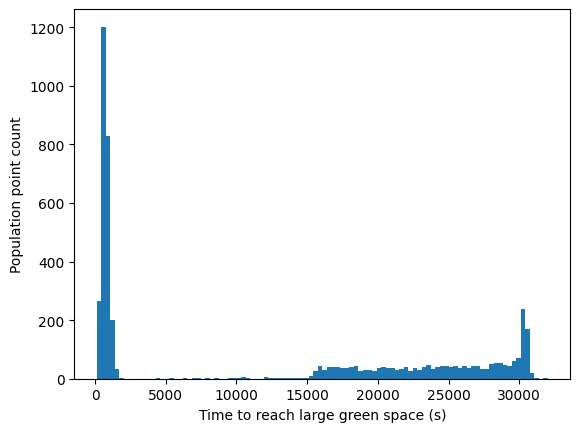

In [33]:
plt.hist(reachbility.values(), bins=100)
plt.xlabel('Time to reach large green space (s)')
plt.ylabel('Population point count')

[2.142327557640172, 10.55885895019857, 0.8962827139947621, 3.183985060246809, 2.2750744120940922, 2.0574547642733707, 10.436042396862183, 10.446369575145347, 0.5352555616764936, 0.5250118896298106, 10.387900511902654, 0.7721106985818236, 10.367269441509148, 0.5141643809467326, 4.0391425498991556, 0.5576116686171481, 10.388030552183995, 0.4938839398517751, 2.022056742345463, 0.5457607780583857, 1.9718178683018825, 10.43730100233196, 10.543948906386829, 10.442063752315557, 4.658691828137426, 0.5839437353082588, 2.2847818550079975, 10.511086673739971, 0.5996172025712828, 10.380671063705593, 1.027035860966389, 10.353830254626606, 3.870877472588842, 0.48468262856710376, 10.41935262718505, 10.39586602491067, 1.2064623059426751, 10.428380124404955, 10.49553770469156, 0.9110090720168458, 10.32287168283512, 10.324295103579683, 0.4926376323633097, 4.689996723733289, 10.521502982469194, 0.9646947937327216, 10.465029203393046, 10.392002667510456, 3.6515184213615246, 10.49429398230312, 1.5547968135

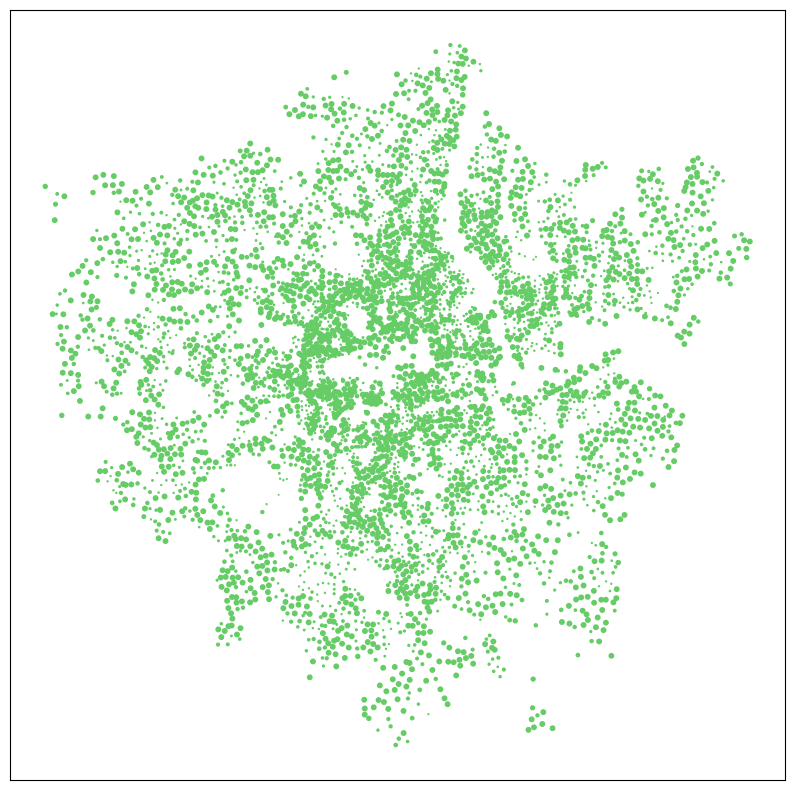

In [30]:
# plot hot spot map by reachbility
nodes = population['lsoa']
m = max(reachbility.values()) + 10
hot_spot_size = [ 0.1 if math.isinf(reachbility[lsoa]) else (m - reachbility[lsoa]) / 3000 for lsoa in nodes ]
print(hot_spot_size)
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(Graph, nodelist=nodes, pos=pos, node_size=hot_spot_size, node_color='#66CC66')

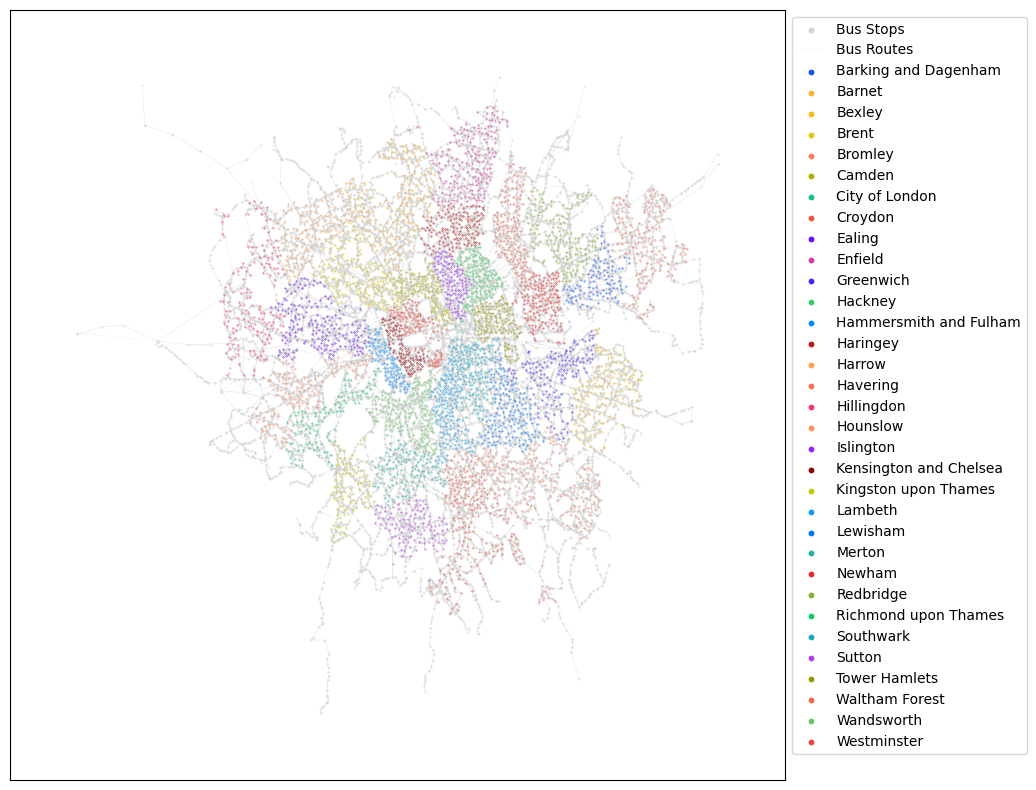

In [12]:
NODE_SIZE = 0.1
EDGE_WIDTH = 0.1
BASE_COLORS = ['#990000', '#EE2C2C', '#EE5C42', '#FF7256', '#FF9966',
          '#FFB90F', '#CDCD00', '#999900', '#66CC66', '#00CC66',
          '#20B2AA', '#0099FF', '#0066FF', '#6600FF', '#B23AEE',
          '#FF3366',]
colors = LinearSegmentedColormap.from_list('chaos', BASE_COLORS, len(councils))

plt.figure(figsize = (10,10))
nodes = bus_stops['id'].values
# print(list(nodes))
nx.draw_networkx_nodes(Graph, nodelist=nodes, pos=pos, node_size=NODE_SIZE, node_color='lightgray', label='Bus Stops')
Graph.edges()
nx.draw_networkx_edges(Graph, pos=pos, width=EDGE_WIDTH, edge_color='lightgray', arrows=False, label='Bus Routes')    # 添加arrows后，时间增长两个数量级

councils_colors = {council: colors(i) for i, council in enumerate(councils)}
population_by_council = population.groupby('council')
for council, populations in population_by_council:
    nx.draw_networkx_nodes(Graph, pos=pos, nodelist=populations['lsoa'], node_size=NODE_SIZE, node_color=[councils_colors[council]], label=council)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=10)
plt.savefig('draw.png', format='png', dpi=1000, bbox_inches='tight')